Open: edit -> notebook setting -> Python3 and GPU accelerator

In [1]:
#!pip install pytorchts

In [2]:
from __future__ import division
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import torch


In [3]:
total_data, train_size, forecast_size = 3500, 2900, 600
url = "https://raw.githubusercontent.com/numenta/NAB/master/data/realTweets/Twitter_volume_AMZN.csv"
df = pd.read_csv(url, header=0, index_col=0, nrows=total_data)

In [4]:
def ARIMA():
    from statsmodels.tsa.arima_model import ARIMA
    new_df_AMZ = pd.DataFrame(df['value']).reset_index().rename(columns={'timestamp': 'ds', 'value': 'y'})
    new_df_AMZ.head()
    X = new_df_AMZ['y'].tolist()
    train, test = X[0:forecast_size], X[train_size:len(X)]
    history = [x for x in train]
    ARIMA_predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=(5, 1, 0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        ARIMA_predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    error = mean_squared_error(test, ARIMA_predictions)
    print('ARIMA MSE: %.3f' % error)
    return ARIMA_predictions




In [5]:
def GlounTS():
    from pts.dataset import ListDataset
    from pts.model.deepar import DeepAREstimator
    from pts import Trainer
    from pts.dataset import to_pandas
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # gluonts crash in my sistem.
    #from gluonts.dataset.common import ListDataset
    #from gluonts.model.deepar import DeepAREstimator
    #from gluonts.trainer import Trainer
    training_data = ListDataset([{"start": df.index[0], "target": df.value[:"2015-03-08 23:22:53"]}], freq="5min")
    estimator = DeepAREstimator(freq="5min",input_size = 43, prediction_length=forecast_size, trainer=Trainer(epochs=20, device=device))
    predictor = estimator.train(training_data=training_data)
    test_data = ListDataset([{"start": df.index[0], "target": df.value[:"2015-03-08 23:22:53"]}], freq="5min")
    GluonTS_prediction = next(predictor.predict(test_data))
    GluonTS_mean_yhat = GluonTS_prediction.mean
    GluonTS_median_yhat = GluonTS_prediction.median
    return GluonTS_mean_yhat.tolist(), GluonTS_median_yhat.tolist(), GluonTS_prediction




In [6]:
def Fbprophet():
    from fbprophet import Prophet
    new_df_AMZ = pd.DataFrame(df['value']).reset_index().rename(columns={'timestamp': 'ds', 'value': 'y'})
    new_df_AMZ.head()
    new_df_AMZ['y'] = np.log(new_df_AMZ['y'])
    model = Prophet()
    model.fit(new_df_AMZ)
    future = model.make_future_dataframe(periods=forecast_size)
    forecast = model.predict(future)
    forecast.head()
    fb_model_close = pd.DataFrame(df['value'])
    fb_model = forecast.set_index('ds').join(fb_model_close)
    fb_model = fb_model[['value', 'yhat', 'yhat_upper', 'yhat_lower']].dropna().tail(forecast_size)
    fb_model['yhat'] = np.exp(fb_model.yhat)
    fb_model['yhat_upper'] = np.exp(fb_model.yhat_upper)
    fb_model['yhat_lower'] = np.exp(fb_model.yhat_lower)
    fbp_history = fb_model['value']
    fbp_yhat = fb_model.yhat
    fbp_yhat_upper = fb_model.yhat_upper
    fbp_yhat_lower = fb_model.yhat_lower
    print("fbprophet MSE:", metrics.mean_squared_error(fbp_yhat, fbp_history))
    print("fbprophet MAE:", metrics.mean_absolute_error(fbp_yhat, fbp_history))
    return fbp_history, fbp_yhat, fbp_yhat_upper, fbp_yhat_lower


In [7]:
def main():
    print("GluonTS!")
    GluonTS_mean_yhat, GluonTS_median_yhat, GluonTS_forecast = GlounTS()
    print("Fbprophet!")
    fbp_history, fbp_yhat, fbp_yhat_upper, fbp_yhat_lower = Fbprophet()
    print("ARIMAX!")
    ARIMA_predictions = ARIMA()
    frame = {'fbp_history': fbp_history, 'fbp_yhat': fbp_yhat, \
             'fbp_yhat_upper': fbp_yhat_upper, 'fbp_yhat_lower': fbp_yhat_lower, \
             'ARIMA_predictions': (np.transpose(ARIMA_predictions).flatten().tolist()), \
             'GlounTS_mean_yhat': (np.transpose(GluonTS_mean_yhat).flatten().tolist()), \
             'GlounTS_median_yhat': (np.transpose(GluonTS_median_yhat).flatten().tolist())}
    result = pd.DataFrame(frame)
    result.plot(fontsize=20)
    plt.show()


GluonTS!


49it [00:03, 12.26it/s, avg_epoch_loss=4.86, epoch=0]
49it [00:04, 11.87it/s, avg_epoch_loss=4.28, epoch=1]
49it [00:04, 11.72it/s, avg_epoch_loss=4.14, epoch=2]
49it [00:04, 12.10it/s, avg_epoch_loss=4.09, epoch=3]
49it [00:03, 12.65it/s, avg_epoch_loss=4.05, epoch=4]
49it [00:03, 13.32it/s, avg_epoch_loss=4.02, epoch=5]
49it [00:04, 12.12it/s, avg_epoch_loss=3.99, epoch=6]
49it [00:03, 12.61it/s, avg_epoch_loss=3.96, epoch=7]
49it [00:04, 11.89it/s, avg_epoch_loss=3.94, epoch=8]
49it [00:04, 12.16it/s, avg_epoch_loss=3.92, epoch=9]
49it [00:04, 12.24it/s, avg_epoch_loss=3.89, epoch=10]
49it [00:04, 12.18it/s, avg_epoch_loss=3.87, epoch=11]
49it [00:04, 11.72it/s, avg_epoch_loss=3.83, epoch=12]
49it [00:04, 11.98it/s, avg_epoch_loss=3.81, epoch=13]
49it [00:04, 12.05it/s, avg_epoch_loss=3.78, epoch=14]
49it [00:04, 11.75it/s, avg_epoch_loss=3.75, epoch=15]
49it [00:04, 12.03it/s, avg_epoch_loss=3.73, epoch=16]
49it [00:04, 11.74it/s, avg_epoch_loss=3.7, epoch=17] 
49it [00:03, 12.83it

Fbprophet!


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


fbprophet MSE: 577.090107756015
fbprophet MAE: 12.484681389373842
ARIMAX!
ARIMA MSE: 343.149


/home/griu/.conda/envs/ts_env/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
/home/griu/.conda/envs/ts_env/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
/home/griu/.conda/envs/ts_env/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
/home/griu/.conda/envs/ts_env/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was d

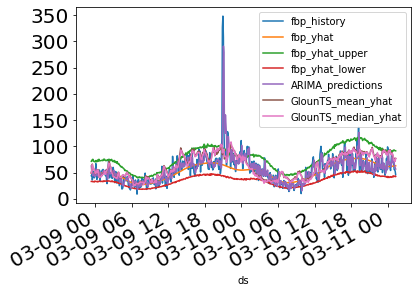

In [8]:
if __name__ == "__main__":
    main()


In [9]:
# 49it [00:18,  2.61it/s, avg_epoch_loss=4.78, epoch=0]
